# How to Reduce Telco Customer Churn
By Joshua Mayes  
2022-07-13

## About this notebook



### Goals
A telecom company is experiencing a high rate of customers discontinuing their service, an event that they refer to as "churn" or "turnover rate".  The company wants to know why their customers are churning so that they can patch any flaws in their service offerings.  They also want to be able to identify which customers are likely to churn in the future so that the customer retention team can pre-emptively contact them and attempt to retain them.

### Outline

First, this notebook will attempt to answer the question "Why are customers churning?".  It will present a collection of features that were identified as drivers of customer churn and evidence of their influence in the form of data visualizations and statistical testing.

Second, it will attempt to answer the question "What can the company do to reduce customer churn?" by recommending changes to the business model that should positively impact the rate of customer churn.

Third, this notebook will demonstrate a simple machine learning model that can be used to monitor customer data, enabling the company to more effectively intervene on customers with a high churn risk.

Finally, this notebook will include an appendix that describes more in depth the process and decisions that went into answering these questions.



### How to reproduce this notebook


This notebook makes use of several python libraries that are not included in the base installation of python.  You can use pip to install them easily by running the following commands in your python shell.
```
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install scipy
%pip install sklearn
```

In [1]:
# Common Data Science Libraries
import pandas as pd
import numpy as np
# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

Additionally some helper libraries have been included to hide complicated code and prevent cluttering of this notebook.

In [2]:
# Helper libraries with custom functions
import wrangle
import model

These libraries can be used to quickly and easily get the data into your python environment.

In [3]:
# Load a cleaned and prepared version of the Telco Churn dataset
data = wrangle.get_tidier_telco_data()
# Split the dataset into smaller datasets to prevent data-leakage when exploring the data and training the model
train, test, validate, verify = wrangle.train_test_validate_verify_split(data)
# Separate the target variable from the feature list for use with Machine Learning models
X_train, y_train = wrangle.x_y_split(train)
X_test, y_test = wrangle.x_y_split(test)

For a more in-depth look at the exploration and research, a detailed walkthrough can be found in [prep-explore.ipynb](./prep-explore.ipynb).  


## Why are customers churning?

Perhaps a stronger way to ask this question would be "What are the most impactful drivers of churn?"

By plotting each column's correllation to the churn column, and cutting away all of columns with the weakest correlation we can get a very good picture of the answer.

Text(0.5, 1.0, 'Correlation with Churn')

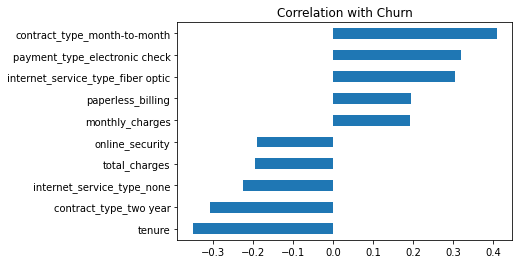

In [4]:
# Get a correllation matrix of the train dataset, then narrow it down to only the churn column
x = train.corr().churn
# We don't care how churn correlates with itself, so drop that row. Then sort the values.
x = x.drop(labels='churn').sort_values()
# Cut away all of the columns with a weak correlation, and plot them in a horizontal bar graph.
# "Weak" is arbitrarily defined as between -0.18 and 0.18
ax = x[abs(x) > .18].plot(kind='barh')
# Give our graph a meaningful title
ax.set_title('Correlation with Churn')

There is a lot of good information in this one chart, but it can be a little difficult to interpret.  The bars that extend to the right represent a positive correlation, while the ones to the left represent a negative correlation.

As a rule of thumb, if a variable has a strong correlation with our target variable (regardless of whether the correlation is positive or negative), then it has a strong predictive power for our target variable.

Unfortunately in this case none of these variables have a particularly strong correlation with our target variable.  A 100% correlation would represent a perfect predictor, but the highest we see here is just below 40%.  However, these variables can still work in concert with one another to help tell the story of why customers are churning and to identify a customer's risk of churn.

Let's take a closer look at the strongest correlators.  We'll start with contract type since it appears twice in our list of strongest correlators, once for the strongest positive correlator (month-to-month contracts) and again as the second strongest negative correlator (two-year contracts).



#### Contract type is a strong predictor for churn

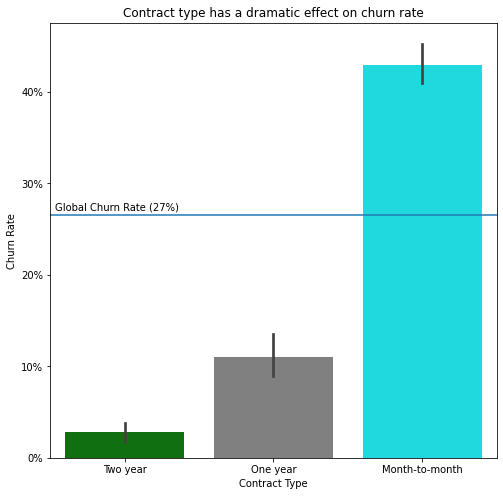

In [5]:
# Manually define the figure size for readability
plt.figure(figsize = (8,8))
# Get the perfect shade of blue
sblue = '#00F7FF' 
# Define the churn-rate for all customers for comparison
gcr = train.churn.mean()
# Draw the plot
sns.barplot(
            data = train, 
            y='churn', 
            x='contract_type', 
            order=['Two year','One year','Month-to-month'],
            palette=['green','grey',sblue]
            ).set(
                title='Contract type has a dramatic effect on churn rate')
# Draw a line on the plot to represent the global churn rate
plt.axhline(gcr)
plt.text(-0.47, gcr+.005, 'Global Churn Rate ({:.0%})'.format(gcr))
# Beautify the figure with some labels and formatting.
plt.ylabel('Churn Rate')
plt.xlabel('Contract Type')
plt.gca().yaxis.set_major_formatter('{:.0%}'.format)

By plotting the percentage of customers who churn with each contract type we can see that the churn-rate for month-to-month customers heavily outweigh the other two contract types.

We can also see the negative correlation of Two-year contracts in effect here. That bar is much shorter than the other two.

Overall, the dramatic shift in churn rates across the different contract types lends this variable to being a very strong predictor of customer churn.  However, it certainly is not the *only* predictor.  

Further down the list of strong correlators we find `internet_service_type_fiber_optic` and `internet_service_type_none`.  Lets examine.

#### Internet Service quality may be negatively impacting customer experience

By doing the same thing for Internet Service types, we can see a very similar story.

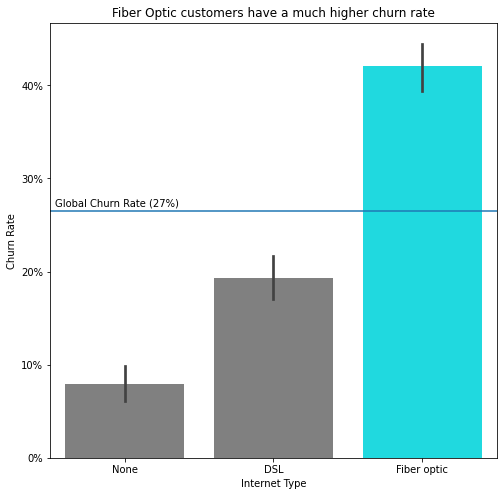

In [6]:
# Using the same method as the chart above, plot the churn rate across internet service types.
plt.figure(figsize = (8,8))
sblue = '#00F7FF'
gcr = train.churn.mean()
churn = sns.barplot(
                    data = train, 
                    y='churn', 
                    x='internet_service_type', 
                    order=['None','DSL','Fiber optic'],
                    palette=['grey','grey',sblue],
                    ).set(
                        title='Fiber Optic customers have a much higher churn rate')
plt.axhline(gcr)
plt.text(-0.47, gcr+.005, 'Global Churn Rate ({:.0%})'.format(gcr))
plt.ylabel('Churn Rate')
plt.xlabel('Internet Type')
plt.gca().yaxis.set_major_formatter('{:.0%}'.format)

These two graphs look very similar right?  Perhaps a bit **too** similar?

There might be a story in that similarity, but before we start jumping to any conclusions we should ask the question: 
>"Is that similarity statistically significant?"

We can answer that question with a $chi^2$ test, which determines what a distribution of values would be if they were independant of one another and compares that with the actual distribution.


##### $ Chi^2 $ test between Contract Type and Internet Type


Statistical Analysis can be a bit weird, but bear with us as we set up the test.

$ \alpha$ (Confidence level) = 0.05, if there is more that a 5% chance that we got this distribution randomly, then we can't assume a relationship  
$ H_0 $ (Null Hypothesis): We are wrong and there is no relationship between contract type and internet type.  
$ H_A $ (Alternate Hypothesis): There is in fact a relationship between the two.  

In [7]:
# Set up a crosstab matrix that represents the distribution of values
inet_ctType = pd.crosstab(train.contract_type, train.internet_service_type)
# Perform the statistical test
model.chi2_test(inet_ctType, alpha=0.05)
# Display the crosstab to make the test results more clear
inet_ctType

Observed

[[ 630 1049  254]
 [ 278  258  188]
 [ 322  202  340]]
---
Expected

[[675 828 429]
 [252 310 160]
 [301 370 191]]
---

chi^2 = 341.3978
degf = 4
p     = 0.0000
---

We reject the null hypothesis


internet_service_type,DSL,Fiber optic,None
contract_type,,,
Month-to-month,630,1049,254
One year,278,258,188
Two year,322,202,340


The statistical test confirms our suspicion (Or more accurately: it makes us more confident that we can assume that our suspicion is true.)

Unfortunately, although the relationship between our two variables is interesting, it's not very actionable.  However, it highlights that there might have been a recent promotion that is contributing to customer churn.  For example, did